In [1563]:
# To Do:
# * Include introduction saying that we could have better data as it relates to genderqueer / non-binary individuals so that programs can be more specific to support these individuals
# Include importance around early childhood development in intro
# Talk about clear lack of data
# Right now I am wondering about the age ranges 5 - 11, 5 - 17, 12 - 17 and if there is a better way to split data-wise than just summing. Until 2005 they didn't split the age range
# Clustering for each country geographically
# R^2 jumps all around


## Introduction/Business Problem

We are currently experiencing the largest refugee crisis that we have globally seen [1]. Over the past decade, the number of refugees and displaced persons has skyrocketed, and it is imperitive that services to support these individuals are in place throughout the relocation process. Importantly, services must be specified to the individual and family level so the we are correctly assisting those who require it. Using historical trends, we can better understand the demographics of displaced individuals.

The United Nations Refugee Agency (UNHCR) collects demographic data around displaced individuals [2]. We can utilize this data to look at the different number of individuals from countrys and locations by age and sex. This will better planning for services such as supporting women and early-age development.

In [1564]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score


In [1565]:
# make df specific to a country

def specify_country(country_unspecified_df, country):
    country_unspecified_df = country_unspecified_df[country_unspecified_df['Country / territory of asylum/residence'] == country]
    
    
def lin_reg(demographic_df_lin_reg, demographic, country, test_size):
    
    specify_country(demographic_df_lin_reg, country)
    
    x_data = demographic_df_lin_reg['Year'].values.reshape(-1, 1)
    y_data = demographic_df_lin_reg[demographic].values.reshape(-1, 1)

    # create training and testing datasets, pick a small test_size as tehre isn't a lot of data
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = test_size)

    # create linear regression object
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_train)

    return [lr.coef_[0][0], lr.intercept_[0], test_size, r2_score(y_train, y_pred)]


###############################################
def lin_reg_qa(demographic_df_qa, demographic, country, test_size):
    
    specify_country(demographic_df_qa, country)
    
    
    x_data = demographic_df_qa['Year'].values.reshape(-1, 1)
    y_data = demographic_df_qa[demographic].values.reshape(-1, 1)
    
    print(x_data)
    print(y_data)

    # create training and testing datasets, pick a small test_size as tehre isn't a lot of data
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = test_size)

    # create linear regression object
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_train)
    
    plt.scatter(x_train, y_train)
    plt.plot(x_train, y_pred, color = 'green')

    return [lr.coef_[0][0], lr.intercept_[0], test_size, r2_score(y_train, y_pred)]
###############################################


def max_r2_lin_reg(max_r2_df, demographic, country):
    
    cols_max_r2 = ['coefficient', 'intercept', 'test_size','r_squared']
    first = []
    # can't go higher than 0.3, otherwise not enough data is in the fitting process
    test_size_range = np.linspace(0.01, 0.3, 100, endpoint = False) 

    for i in test_size_range:
        first.append(lin_reg(max_r2_df, [demographic], country, i))
    
    r2_df = pd.DataFrame(first, columns = cols_max_r2)


    max_r2 = r2_df[r2_df['r_squared'] == r2_df['r_squared'].max()].reset_index(drop = True)
    return max_r2


def lr_dictionary_generator(dictionary_df, demographic, country):
    
    optimal_test_size = max_r2_lin_reg(max_r2_df = dictionary_df, demographic = demographic, country = country)
    
    final_lin_reg = lin_reg(demographic_df_lin_reg = dictionary_df, demographic = demographic, country = country, test_size = optimal_test_size.loc[0, 'test_size'])
    

    return [country, demographic, final_lin_reg[0], final_lin_reg[1], optimal_test_size.loc[0, 'r_squared'],]


In [1566]:
# data: http://popstats.unhcr.org/en/demographics
demographics_df = pd.read_csv('/Users/jonathan/Desktop/refugee_project/UNHCR Refugee Data/unhcr_popstats_export_demographics_2019_12_23_152351.csv', header = 2)

demographics_df.head()

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,West,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720
2,2001,Afghanistan,North,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
3,2001,Afghanistan,Kabul,NaN,NaN,1.0,NaN,1,NaN,0.0,2,NaN,NaN,0.0,NaN,2,NaN,0.0,2
4,2001,Afghanistan,Herat,NaN,NaN,0.0,NaN,1,NaN,0.0,1,NaN,NaN,0.0,NaN,1,NaN,0.0,1


In [1567]:
# Cleaning data

# convert ages to integers because you can't have half of a person
# assuming that all '*' values are 0
def clean_convert(col):
    demographics_df[col] = demographics_df[col].fillna(0).replace('*', 0).astype(int)
    
    
demographics_columns = ['Female 0-4','Female 5-11','Female 5-17','Female 12-17',
                        'Female 18-59','Female 60+','F: Unknown','F: Total',
                        'Male 0-4','Male 5-11','Male 5-17','Male 12-17',
                        'Male 18-59','Male 60+','M: Unknown','M: Total']

for col in demographics_columns:
    clean_convert(col)
    
demographics_df.head()

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2001,Afghanistan,Various,14335,0,45451,0,99880,19234,412004,590904,14716,0,47522,0,114965,13025,435492,625720
2,2001,Afghanistan,North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2001,Afghanistan,Kabul,0,0,1,0,1,0,0,2,0,0,0,0,2,0,0,2
4,2001,Afghanistan,Herat,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1


In [1568]:
# The 'total' columns are sums of all other columns for each gender, but there is overlap among a few columns
def add_cols(col, col_list):
    demographics_df[col] = demographics_df[col_list].sum(axis = 1)
    

add_cols('Female 5-17',['Female 5-11','Female 5-17','Female 12-17'])

add_cols('Male 5-17',['Male 5-11','Male 5-17','Male 12-17'])

cols_to_drop = ['Female 5-11', 'Female 12-17', 'Male 5-11', 'Male 12-17','Location Name']
    
demographics_df = demographics_df.drop(cols_to_drop, axis = 1)
demographics_df = demographics_df.groupby(['Year','Country / territory of asylum/residence']).sum().reset_index()

demographics_df.head()

# good to this point

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,14335,45452,99882,19234,412004,590907,14716,47522,114968,13025,435492,625723
1,2001,Albania,14,37,91,15,0,157,18,37,117,16,0,188
2,2001,Algeria,13038,29253,33630,185,0,76106,13001,31748,33658,917,0,79324
3,2001,Angola,860,2959,2485,83,0,6387,990,2940,1814,119,0,5863
4,2001,Argentina,18,91,221,7,0,337,29,66,493,23,0,611


[[2001]
 [2001]
 [2001]
 ...
 [2018]
 [2018]
 [2018]]
[[ 45452]
 [    37]
 [ 29253]
 ...
 [478645]
 [ 13757]
 [  2232]]


[957.1066708424644, -1909535.6718402645, 0.3, 0.00666748305321474]

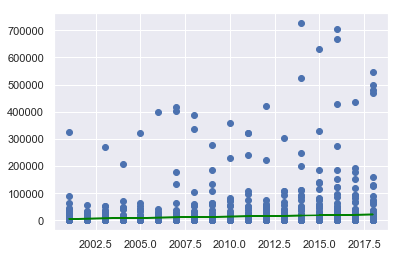

In [1569]:
# something is wrong here


# return [lr.coef_[0][0], lr.intercept_[0], test_size, r2_score(y_train, y_pred)]
lin_reg_qa(demographics_df, 'Female 5-17', 'Afghanistan', 0.3)


In [1570]:
country_list = pd.DataFrame({'country': ['Malawi', 'Iceland', 'Samoa', 'Rep. of Korea', 'Burkina Faso', 'Bosnia and Herzegovina']})


demographics_list = pd.DataFrame({'demographic': ['Female 0-4', 'Female 5-17', 
                                                  'Female 18-59', 'Female 60+', 
                                                  'Male 0-4', 'Male 5-17', 
                                                  'Male 18-59', 'Male 60+',
                                                 ]})

cols_final_df = ['country', 'demographic', 'coefficient', 'intercept', 'r_squared']
final_df = []

for demographic in demographics_list['demographic']:
    for country in country_list['country']:
        final_df.append(lr_dictionary_generator(demographics_df, demographic, country))
    

final_df = pd.DataFrame(final_df, columns = cols_final_df)
final_df = final_df.sort_values(by = 'country')

final_df #.to_csv('/Users/jonathan/Desktop/refugee_project/regression_values_overall.csv', index = False)

,country,demographic,coefficient,intercept,r_squared
23,Bosnia and Herzegovina,Female 60+,84.897188,-1.683645e+05,0.004982
41,Bosnia and Herzegovina,Male 18-59,1337.549343,-2.667984e+06,0.011751
35,Bosnia and Herzegovina,Male 5-17,1090.044006,-2.175012e+06,0.014855
29,Bosnia and Herzegovina,Male 0-4,614.590810,-1.228463e+06,0.013314
17,Bosnia and Herzegovina,Female 18-59,1173.067962,-2.337020e+06,0.013437
11,Bosnia and Herzegovina,Female 5-17,1529.876984,-3.058737e+06,0.013333
47,Bosnia and Herzegovina,Male 60+,30.988515,-6.037493e+04,0.005951
5,Bosnia and Herzegovina,Female 0-4,504.467484,-1.007815e+06,0.014533
16,Burkina Faso,Female 18-59,1388.002012,-2.768767e+06,0.011987
46,Burkina Faso,Male 60+,88.001502,-1.747608e+05,0.005166


In [1571]:
# x_data = demographics_df_country['Year'].values.reshape(-1, 1)
# y_data = demographics_df_country['Female 0-4'].values.reshape(-1, 1)

# # create training and testing datasets, pick a small test_size as tehre isn't a lot of data
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15)

# # create linear regression object
# lr = LinearRegression()
# lr.fit(x_train, y_train)
# y_pred = lr.predict(x_train)

# print('The equation in y = mx + b form is:\n','y = ',lr.coef_,'x + ',lr.intercept_,'\n')
        
# plt.scatter(x_train, y_train)
# plt.plot(x_train, y_pred, color = 'green')

# # R^2 score
# print('The R^2 score is ',r2_score(y_train, y_pred))


# year = 2016
# print('The predicted value for {} is: '.format(year), (lr.coef_ * year) + (lr.intercept_))

References:

[1]: https://www.unhcr.org/blogs/statistics-refugee-numbers-highest-ever/
[2]: http://popstats.unhcr.org/en/demographics